# Plotting the routes
Using Geopandas

In [2]:
import pandas as pd
import geopandas as geopandas
import os
import glob
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', None)

In [ ]:
gps_dict = {}

path = os.getcwd() + "\GPS-data"
sheets = glob.glob(os.path.join(path, "*.xlsx"))
# loop over the list of route files
for sheet in sheets:
    gps_dict[sheet.split("\\")[-1].replace(".xlsx", "")[0:17]] = pd.read_excel(sheet)

# there should be 21 bike routes (for now 24 why I dont know!) in the list
print("Amount of excel files converted to pandas dataframes "+str(len(gps_dict)))
print()

for routename, dataframe in gps_dict.items():
    print(routename)
    display(HTML(dataframe.head(5).to_html()))

In [7]:
df_route = gps_dict['01-12-2021_RouteN']

gdf = geopandas.GeoDataFrame(
    df_route, geometry=geopandas.points_from_xy(df_route.Longitude.to_list(), df_route.Latitude.to_list()))

## Plot an route
Using: https://public.opendatasoft.com/explore/dataset/georef-netherlands-postcode-pc4/table/?refine.prov_name=Groningen&refine.gem_name=Groningen&location=10,53.21082,6.61855&basemap=jawg.light 

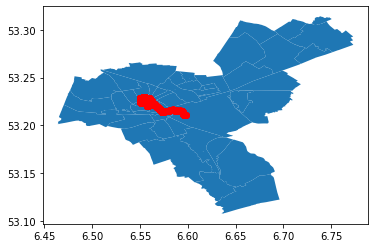

In [8]:
ax = geopandas.read_file('GEO-data/georef-netherlands-postcode-pc4.shp')


gdf.plot(ax=ax, color='red')

plt.show()

In [48]:
# https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0
shp_zip_codes = geopandas.read_file("GEO-data/georef-netherlands-postcode-pc4.shp")[["pc4_code", "geometry"]]
#rename column
shp_zip_codes.columns = ["Postcode", "geometry"]

In [49]:
df_dabba = pd.read_excel("Dabba.xlsx", names = ["Klanteigenaar", "Aantal", "Adres", "Postcode", "Volgnummer"], usecols="B,F,G,H,R")
# change the 6 postal code to the first 4 numberecal codes
df_dabba["Postcode"] = df_dabba["Postcode"].apply(lambda x:x[:4]) 

In [50]:
df_dabba["Postcode"].unique()

array(['9726', '9731', '9711', '9724', '9717', '9741', '9721', '9714',
       '9722', '9723', '9718', '9713', '9715', '9737', '9712', '9742',
       '9732', '9727', '9743', '9725', '9734', '9728', '9716', '9736',
       '9735', '9733', '9747', '9719'], dtype=object)

In [51]:
#remove postcodes and geometry from the shape file if not in the dabba dataframe 

for i, row in shp_zip_codes.iterrows(): #dit gaat nog niet goed
    if row["Postcode"] not in df_dabba["Postcode"].values:
        shp_zip_codes.drop(i)


,Postcode,geometry
12,9479,"POLYGON ((6.68653 53.14895, 6.68656 53.14894, ..."
41,9613,"POLYGON ((6.66007 53.23642, 6.66007 53.23637, ..."
0,9614,"POLYGON ((6.70948 53.23641, 6.70951 53.23625, ..."
15,9622,"POLYGON ((6.70075 53.25651, 6.70174 53.25604, ..."
25,9711,"MULTIPOLYGON (((6.57755 53.21959, 6.57763 53.2..."
36,9712,"POLYGON ((6.56178 53.22725, 6.56178 53.22724, ..."
10,9713,"MULTIPOLYGON (((6.58560 53.23422, 6.58782 53.2..."
16,9714,"POLYGON ((6.58512 53.23460, 6.58300 53.23360, ..."
26,9715,"POLYGON ((6.56963 53.23961, 6.56985 53.23954, ..."
23,9716,"POLYGON ((6.56549 53.23591, 6.56517 53.23544, ..."


In [24]:
gdf_zip_codes["Counts"] = df_dabba["Postcode"].map(df_dabba["Postcode"].value_counts())
gdf_zip_codes

,Postcode,geometry,Counts
0,9614,"POLYGON ((6.70948 53.23641, 6.70951 53.23625, ...",481
1,9731,"POLYGON ((6.58247 53.24621, 6.58255 53.24588, ...",805
2,9737,"MULTIPOLYGON (((6.60207 53.24898, 6.60202 53.2...",1531
3,9723,"POLYGON ((6.64596 53.22445, 6.64611 53.22418, ...",470
4,9745,"POLYGON ((6.48105 53.23099, 6.48108 53.23099, ...",1531
5,9753,"POLYGON ((6.63974 53.17642, 6.63935 53.17590, ...",629
6,9797,"POLYGON ((6.66778 53.29159, 6.66813 53.29131, ...",529
7,9792,"POLYGON ((6.74671 53.30637, 6.74868 53.30409, ...",1068
8,9728,"POLYGON ((6.56277 53.20323, 6.56280 53.20308, ...",1008
9,9732,"MULTIPOLYGON (((6.63070 53.23928, 6.63096 53.2...",942


In [22]:
df_dabba["Postcode"].value_counts()

9713    1850
9712    1795
9711    1531
9718    1101
9728    1093
9721    1068
9714    1008
9722     942
9731     805
9742     802
9723     767
9743     739
9715     674
9717     629
9727     597
9725     566
9741     529
9736     509
9726     481
9724     470
9737     468
9732     432
9716     355
9734     326
9733     198
9747      40
9735      38
9719       1
Name: Postcode, dtype: int64

In [ ]:
# alle stops plotten en daar de area (A) bereken
# m = aantal fietsen 
# n = number of delivery addresses within area
# Ai = gemiddelde fietsen oppervlakte A/m = area fietsen
# k * sqr(n*A)
# For D sum all the areas (A's) and divide them into 2, 4, 8, 16, ect. 
# TODO
# 1. Maak df_dabba bezorg postcodes 4 cijferig, want the shape file van Groningen heeft alleen postcode gebieden (xxxx)
# 2. 